In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

from pandas.io.json import json_normalize
import json
import operator

from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error,r2_score
# from import lightgbm
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense

In [2]:
# all the functions defined for data cleaning, manipulation, and feature engineering
def str_to_list(x):
    try:
        return ast.literal_eval(x)
    except:
        pass

def genre_decoder(row,genre):
    try:
        value=0
        for dic in row:
            if dic['name'] == genre:
                value= True
                break
        return value   
    except: 
        return False
    
def column_decoder(row,item):
    try:
        value=0
        for dic in row:
            if dic['name'] == item:
                value= 1
                break
    except: 
        pass   
    return value

def item_in_dict(dict,key):
    try:
        if dict:
            return dict[key] 
    except:
        return 0

def item_in_list_or_not(list_of_dicts,key,item):
    try:
        output=0
        for dict in list_of_dicts:
            if dict[key]== item:
                output=1
                break
        return  output       
    except:
        return  output  
    
def first_in_list_or_not(list_of_dicts,key,item):
    try:
        output=0
        if list_of_dicts[0][key]== item:
            output=1
        return  output       
    except:
        return  output  
    
def get_first_item_in_list(list_of_dicts,key):
    try:
        return  list_of_dicts[0][key]       
    except:
        return 0 
    
def production_in_top10(production_comp):
    try:
        for item in production_comp:
            if item['id'] in top_10_production_companies:
                return 1
    except:
        pass
    return 0

def tops(x,dic,key):
    num_times = 0
    try:
        for item in x:
            if item[key] in dic:
                num_times +=1
    except:
        pass
    return num_times

def count_items(x):
    try:
        return len(x)
    except:
        return 0
  


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Exploration

binned_budget
=0                       812
0-10                      12
10-100                     2
100-1000                   4
1000-10000                 5
10000-100000              18
100000-1000000           135
1000000-10000000         642
10000000-100000000      1245
100000000-1000000000     125
Name: budget, dtype: int64
3000
binned_budget
=0                      1211
0-10                      16
10-100                     9
100-1000                   9
1000-10000                 3
10000-100000              37
100000-1000000           206
1000000-10000000         934
10000000-100000000      1773
100000000-1000000000     200
Name: budget, dtype: int64
4398


<BarContainer object of 10 artists>

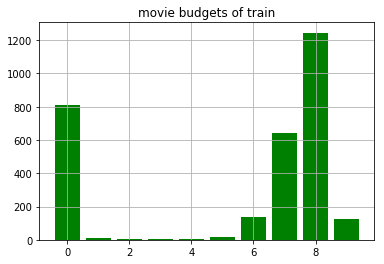

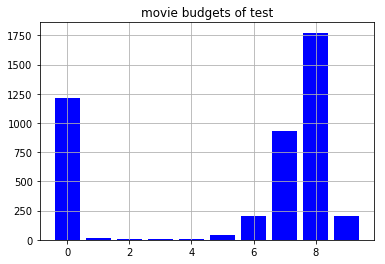

In [4]:
train_m=train.copy()
test_m=test.copy()

bins=[-1,0, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]
bins_name=['=0']
for i in range(len(bins)-2):
    bins_name.append(str(bins[i+1])+'-'+str(bins[i+2])) 

train_m['binned_budget']=pd.cut(train_m['budget'],bins,labels=bins_name)
print(train_m.groupby('binned_budget')['budget'].count())
print(train_m.groupby('binned_budget')['budget'].count().sum())


plt.title("movie budgets of train")
plt.grid()
plt.bar(range(len(train_m.groupby('binned_budget')['budget'].count())),train_m.groupby('binned_budget')['budget'].count(),
       color='green')

test_m['binned_budget']=pd.cut(test_m['budget'],bins,labels=bins_name)
print(test_m.groupby('binned_budget')['budget'].count())
print(test_m.groupby('binned_budget')['budget'].count().sum())


plt.figure()
plt.title("movie budgets of test")
plt.grid()
plt.bar(range(len(test_m.groupby('binned_budget')['budget'].count())),test_m.groupby('binned_budget')['budget'].count(),
       color='blue')



number of movies with budgets > 1000 
 2170


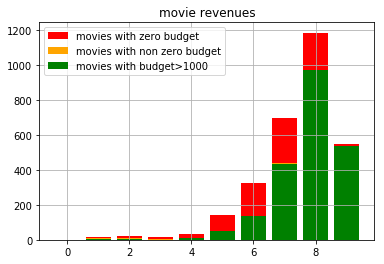

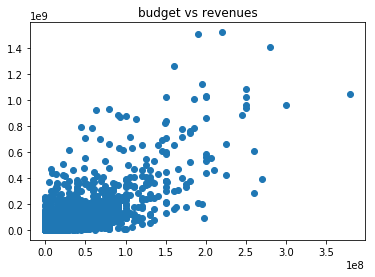

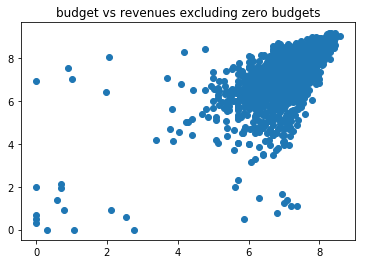

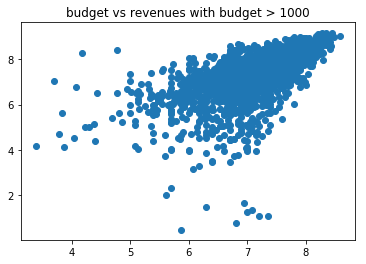

In [5]:
plt.figure()
plt.title("movie revenues")
train_m['binned_revenue']=pd.cut(train_m['revenue'],bins,labels=bins_name)
plt.bar(range(len(train_m.groupby('binned_revenue')['revenue'].count())),train_m.groupby('binned_revenue')['revenue'].count(),
       color='r',align='center',label='movies with zero budget')

train_m['binned_revenue']=pd.cut(train_m.loc[train_m['budget']>0]['revenue'],bins,labels=bins_name)
plt.bar(range(len(train_m.groupby('binned_revenue')['revenue'].count())),train_m.groupby('binned_revenue')['revenue'].count(),
        color='orange',align='center',label='movies with non zero budget')

train_m['binned_revenue']=pd.cut(train_m.loc[train_m['budget']>1000]['revenue'],bins,labels=bins_name)
plt.bar(range(len(train_m.groupby('binned_revenue')['revenue'].count())),train_m.groupby('binned_revenue')['revenue'].count(),
        color='green',align='center',label='movies with budget>1000')
plt.legend()
plt.grid()

plt.figure()
plt.title("budget vs revenues")
plt.scatter(train_m['budget'],train_m['revenue'])

plt.figure()
plt.title("budget vs revenues excluding zero budgets")
plt.scatter(np.log10(train_m.loc[train_m['budget']>0]['budget']),np.log10(train_m.loc[train_m['budget']>0]['revenue']))
plt.figure()
plt.title("budget vs revenues with budget > 1000")
plt.scatter(np.log10(train_m.loc[train_m['budget']>1000]['budget']),np.log10(train_m.loc[train_m['budget']>1000]['revenue']))

print('number of movies with budgets > 1000 \n',train_m.loc[train_m['budget']>1000]['budget'].count())


# Data Cleaning

In [5]:
# copy train and test dataframes into train2 and test2 dataframes 
train2=train.copy()
train2=train2.drop(columns=['revenue'])
test2=test.copy()
# print('list of original features:')
# print(train2.columns)
# add the name of new columns in a list to keep track of them
list_new_columns=[]
# #================================================================================

test2.iloc[test2.loc[test2['release_date'].isna()].index,test2.columns.get_loc('release_date')]='05/01/2000'
# extract year and month of movies release date and create separate columns for each one
list_new_columns.append('release_day')  
list_new_columns.append('release_month')   
list_new_columns.append('release_year')   
for df in [train2,test2]:
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[df['release_year'] <= 18 , "release_year"] += 2000  
    df.loc[(df['release_year'] > 18) & (df['release_year'] < 100), "release_year"] += 1900
#--------------------------------------------------------------------------------------
#convert type of categorical columns from str to list using str_to_list function
columns_to_convert=['genres','production_companies','production_countries',
                    'belongs_to_collection','spoken_languages',
                    'homepage','Keywords', 'cast', 'crew']
# convert all the columns with json format, and pass on empty rows 
for df in [train2,test2]:
    for column in columns_to_convert:
        try:
            df[column]=df[column].apply(str_to_list)
        except:
            pass
#================================================================================
# # count the number of characters for selected features, and return 0 for NAN rows
# columns_to_count_len=['genres','production_countries','production_companies',
#                       'spoken_languages','Keywords', 'cast', 'crew']
columns_to_count_len=['crew']
for column in columns_to_count_len:
    list_new_columns.append(column+'_ct')
    try:
        train2[column+'_ct']=train2[column].apply(count_items)
        test2[column+'_ct']=test2[column].apply(count_items)
    except:
        train2[column+'_ct']=0
        test2[column+'_ct']=0
        
#================================================================================
# create two columns for top m production companies and top n cast 
top_list={}
num=[100,200]
for column in ['production_companies','cast']:
    dic={}
    for row in train2[column]:
        try:
            for item in row:
                if item['name'] in dic.keys():
                    dic[item['name']] += 1
                else:
                    dic[item['name']] = 1   
        except:
            pass

    sorted_dic = sorted(dic.items(), key = operator.itemgetter(1),reverse = True)
    top_list[column] = [x[0] for x in sorted_dic][:num.pop(0)]
    
    list_new_columns.append('in_top_'+column)
    for df in [train2,test2]:
        df['in_top_'+column] = df[column].apply(lambda x: tops(x,top_list[column],'name'))     
#================================================================================
# creat two new columns for countries column: 
# one to check if one of the production countries is US, and the other one if US is listed first                   
train2['US_or not']=train2['production_countries'].apply(lambda x: item_in_list_or_not(x,'iso_3166_1','US')).astype('category')
train2['US_is_first']=train2['production_countries'].apply(lambda x: first_in_list_or_not(x,'iso_3166_1','US')).astype('category')
list_new_columns.append('US_is_first')

test2['US_or not']=test2['production_countries'].apply(lambda x: item_in_list_or_not(x,'iso_3166_1','US')).astype('category')
test2['US_is_first']=test2['production_countries'].apply(lambda x: first_in_list_or_not(x,'iso_3166_1','US')).astype('category')
list_new_columns.append('US_or not') 

# #================================================================================
# # train2['en_ornot'] = np.where(train2['original_language']=='en',1,0)
# # test2['en_ornot'] = np.where(test2['original_language']=='en',1,0)

# # create a new column to show wether a movie belongs to a collection or not
# train2['if_belongs_to_collection'] = np.where(train2['belongs_to_collection'].isnull(),0,1)
# train2['if_belongs_to_collection'] = train2['if_belongs_to_collection'].astype('category')
# test2['if_belongs_to_collection'] = np.where(test2['belongs_to_collection'].isnull(),0,1)
# test2['if_belongs_to_collection'] = test2['if_belongs_to_collection'].astype('category')

#================================================================================
### flatten out all of the dictionary-type of columns
#create new column for each genre and production_countries
# for column in ['genres','production_countries']:
#     column_list=[]
#     for row in train2[column]:
#         try:
#             for dic in row:
#                 if dic['name'] not in column_list:
#                     column_list.append(dic['name'])
#         except:
#             pass

#     #encode the genres column and country    
#     for item in column_list:
#         list_new_columns.append(item)
#         train2[item]=train2[column].apply(lambda x: column_decoder(x,item)).astype('category')
#         test2[item]=test2[column].apply(lambda x:column_decoder(x,item)).astype('category')


#************************************** scale and encode ***********************************************************
train2['train'] = 1
test2['train'] = 0

combined = pd.concat([train2,test2])

# Minmax scaling based on combined dataset
# numerical_columns= combined.select_dtypes(['int','int64','float'])
numerical_columns= combined[['budget', 'popularity', 'runtime', 'crew_ct',
       'in_top_production_companies', 'in_top_cast']]

# Encoding based on combined dataset
combined = pd.get_dummies(combined,columns = ['release_year','release_month']) 


for column in numerical_columns:    
    scaler = MinMaxScaler()
    fitted = scaler.fit(combined[column].values.reshape(-1,1))
    combined[column] = fitted.transform(combined[column].values.reshape(-1,1))

### flatten out all of the dictionary-type of columns
#create new column for each genre and production_countries
for column in ['genres','production_countries']:
    column_list=[]
    for row in combined[column]:
        try:
            for dic in row:
                if dic['name'] not in column_list:
                    column_list.append(dic['name'])
        except:
            pass

    #encode the genres column and country    
    for item in column_list:
        list_new_columns.append(item)
        combined[item]=combined[column].apply(lambda x: column_decoder(x,item)).astype('category')

combined['runtime'].fillna(combined['runtime'].mean(),inplace = True)


train2 = combined[combined['train'] == 1]
test2 = combined[combined['train'] == 0]
train2.drop(['train'],axis = 1, inplace = True)
test2.drop(['train'],axis = 1, inplace = True)
print('#'*40)
print('train2 size:  ',train2.shape)
print('test2 size:  ',test2.shape)

# #=================================Remove columns===============================================

#Columns to be removed
to_remove = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_title'
            ,'poster_path','production_companies','production_countries','release_date',#'spoken_languages_ct',
            'tagline','Keywords','cast','crew','spoken_languages','title','original_language','status','release_day']

train2 = train2.drop(columns = to_remove)
test2=test2.drop(columns = to_remove)
print(len(train2.columns),' features of train 2 will be used for training')

# # #************************************** Training Models ***********************************************************
#train model1 using movies with non zero budget values
y = train['revenue'].apply(lambda x: x/10**4)
X_train, X_test,y_train, y_test = train_test_split(train2,y,test_size = 0.2,random_state=12)

models1 = []
for model in [linear_model.LinearRegression(),
              linear_model.Lasso(alpha=0.1),
              RandomForestRegressor(n_estimators=500),
             GradientBoostingRegressor(),
              
             ]:
    model.fit(X_train,y_train)
    models.append(model)
    
    print('Train Set',str(model).split("(")[0],model.score(X_train,y_train))
    print('Test Set',str(model).split("(")[0],model.score(X_test,y_test))
    print(mean_squared_error(y_test,model.predict(X_test)),r2_score(y_test,model.predict(X_test)))
    print('-'*40)


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


########################################
train2 size:   (3000, 256)
test2 size:   (4398, 256)
236  features of train 2 will be used for training


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
# # #************************************** Training Models ***********************************************************
#train model1 using movies with non zero budget values
y1 = train.loc[train['budget']!=0,]['revenue'].apply(lambda x: x/10**4)
X1_train, X1_test,y1_train, y1_test = train_test_split(train2.loc[train2['budget']!=0,],y1,test_size = 0.2,random_state=12)

models1 = []
for model in [linear_model.LinearRegression(),
              linear_model.Lasso(alpha=0.1),
              RandomForestRegressor(n_estimators=500),
             GradientBoostingRegressor(),
             ]:
    model.fit(X1_train,y1_train)
    models1.append(model)
    
    print('Train Set',str(model).split("(")[0],model.score(X1_train,y1_train))
    print('Test Set',str(model).split("(")[0],model.score(X1_test,y1_test))
    print(mean_squared_error(y1_test,model.predict(X1_test)),r2_score(y1_test,model.predict(X1_test)))
    print('-'*40)

Train Set LinearRegression 0.664729530951689
Test Set LinearRegression -3.842299803420871e+19
1.030740518891134e+28 -3.842299803420871e+19
----------------------------------------
Train Set Lasso 0.6647238439897025
Test Set Lasso 0.566435562105057
116308579.90068856 0.566435562105057
----------------------------------------
Train Set RandomForestRegressor 0.9535149160642216
Test Set RandomForestRegressor 0.6395175053548873
96703519.4002466 0.6395175053548872
----------------------------------------
Train Set GradientBoostingRegressor 0.847023505074383
Test Set GradientBoostingRegressor 0.6248612148168524
100635235.63455588 0.6248612148168524
----------------------------------------


In [10]:
# # #************************************** Training Models ***********************************************************
#train model1 using movies with zero budget values
y2 = train.loc[train['budget'] ==0,'revenue'].apply(lambda x: x/10**4)
X2_train, X2_test,y2_train, y2_test = train_test_split(train2.loc[train2['budget']==0,].drop(columns=["budget"]),y2,test_size = 0.2,random_state=12)

models2 = []
for model in [linear_model.LinearRegression(),
              linear_model.Lasso(alpha=0.1),
              RandomForestRegressor(n_estimators=500),
             GradientBoostingRegressor(),
             ]:
    model.fit(X2_train,y2_train)
    models2.append(model)
    
    print('Train Set',str(model).split("(")[0],model.score(X2_train,y2_train))
    print('Test Set',str(model).split("(")[0],model.score(X2_test,y2_test))
    print(mean_squared_error(y2_test,model.predict(X2_test)),r2_score(y2_test,model.predict(X2_test)))
    print('-'*40)

Train Set LinearRegression 0.41786216943970156
Test Set LinearRegression -3.673210487485371e+20
1.0858930839655727e+27 -3.673210487485371e+20
----------------------------------------
Train Set Lasso 0.4177463707350597
Test Set Lasso -0.7010702970035301
5028790.147334983 -0.7010702970035301
----------------------------------------
Train Set RandomForestRegressor 0.875379239538487
Test Set RandomForestRegressor -0.2787049276947653
3780172.255707068 -0.2787049276947653
----------------------------------------
Train Set GradientBoostingRegressor 0.8074937567054249
Test Set GradientBoostingRegressor -0.2678747034640927
3748155.3984375168 -0.2678747034640927
----------------------------------------


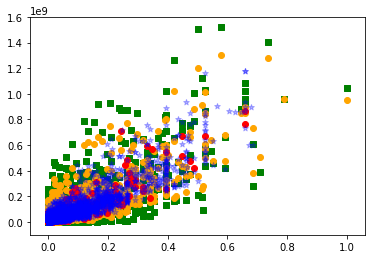

In [76]:
#### training the rnf model using not zero budget values did not improve the score.

plt.figure()
plt.scatter(train2['budget'],train['revenue'],color='green',marker='s')
plt.scatter(X_train['budget'],(models[2].predict(X_train)*10**4),color='orange')
plt.scatter(X_test['budget'],(models[2].predict(X_test)*10**4),color='red')
plt.scatter(test2['budget'],(models[2].predict(test2)*10**4),marker='*',color='blue',alpha=.3)


In [77]:
test['revenue'] = models[2].predict(test2)
test['revenue']=test['revenue'].apply(lambda x: x*10**4)
test[['id','revenue']].to_csv('test_submission.csv',index = False, header = True)
!kaggle competitions submit -f 'test_submission.csv' -m 'rnf-all' tmdb-box-office-prediction
test=test.drop(columns=['revenue'])

100%|██████████████████████████████████████| 99.5k/99.5k [00:02<00:00, 47.5kB/s]
Successfully submitted to TMDB Box Office Prediction

# TensorFlow Try

In [55]:
X_train, X_test,y_train, y_test = train_test_split(train2,y,test_size = 0.2,random_state=46)
nn_model = Sequential()
nn_model.add(Dense(units = 150, activation = 'relu',input_dim =(train2.shape)[1]))
nn_model.add(Dense(units = 100, activation = 'relu'))
nn_model.add(Dense(units = 1, activation = 'linear'))
nn_model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['mean_squared_error'])
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 150)               35550     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 50,751
Trainable params: 50,751
Non-trainable params: 0
_________________________________________________________________


In [56]:
nn_model.fit(X_train,np.log10(y_train*10**4),epochs = 100,shuffle = True)

Epoch 1/100
2400/2400 [==============================] - 1s 274us/step - loss: 11.5320 - mean_squared_error: 11.5320
Epoch 2/100
2400/2400 [==============================] - 0s 106us/step - loss: 1.3756 - mean_squared_error: 1.3756
Epoch 3/100
2400/2400 [==============================] - 0s 146us/step - loss: 1.0850 - mean_squared_error: 1.0850
Epoch 4/100
2400/2400 [==============================] - 0s 105us/step - loss: 0.9472 - mean_squared_error: 0.9472
Epoch 5/100
2400/2400 [==============================] - 0s 115us/step - loss: 0.8574 - mean_squared_error: 0.8574
Epoch 6/100
2400/2400 [==============================] - 0s 118us/step - loss: 0.8066 - mean_squared_error: 0.8066
Epoch 7/100
2400/2400 [==============================] - 0s 94us/step - loss: 0.7517 - mean_squared_error: 0.7517
Epoch 8/100
2400/2400 [==============================] - 0s 98us/step - loss: 0.7183 - mean_squared_error: 0.7183
Epoch 9/100
2400/2400 [==============================] - 0s 104us/step - loss: 0

In [57]:
nn_model.evaluate(X_test,np.log10(y_test*10**4))

600/600 [==============================] - 0s 242us/step


[1.7910456411043802, 1.7910456411043802]

(-10000, 1600000000.0)

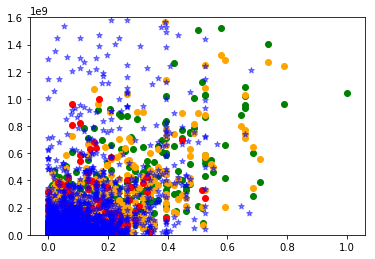

In [74]:
plt.figure()
plt.scatter(train2['budget'],train['revenue'],color='green')
predicts=nn_model.predict(X_train)
predicted_revenue=[]
for i in predicts:
    predicted_revenue.append((i.tolist()[0]))   
plt.scatter(X_train['budget'],[10**x for x in predicted_revenue],color='orange')
predicts=nn_model.predict(X_test)
predicted_revenue=[]
for i in predicts:
    predicted_revenue.append((i.tolist()[0])) 
plt.scatter(X_test['budget'],[10**x for x in predicted_revenue],color='red')
predicts=nn_model.predict(test2)
predicted_revenue=[]
for i in predicts:
    predicted_revenue.append((i.tolist()[0]))
plt.scatter(test2['budget'],[10**x for x in predicted_revenue],marker='*',color='blue',alpha=.5)
plt.ylim(-10000,1.6*10**9)

100%|████████████████████████████████████████| 100k/100k [00:02<00:00, 49.4kB/s]
Successfully submitted to TMDB Box Office Prediction

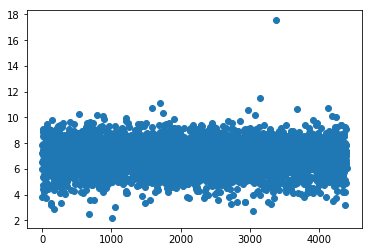

In [68]:
predicts=nn_model.predict(test2)
predicted_revenue=[]
for i in predicts:
    predicted_revenue.append((i.tolist()[0]))  
test['revenue'] =predicted_revenue
test['revenue']=test['revenue'].apply(lambda x: 10**x)
test[['id','revenue']].to_csv('test_submission.csv',index = False, header = True)
!kaggle competitions submit -f 'test_submission.csv' -m 'nn-all' tmdb-box-office-prediction
test=test.drop(columns=['revenue'])